In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tabulate import tabulate

# Congruential Random Number Generator

A congruential random number generator constructs a sequence of pseudorandom numbers using a discontinuous piecewise linear equation. The simplest form of a congruential random number generator can be defined as:

$x_i = (cx_{i-1})\mod p$

where $c$, $p$, and a seed value $x_0$ are chosen integers. The iteraton generates random numbers $x_i$ in the interval $[0, p-1]$. To transform this into a normalized sequence $z_i$ in $[0, 1)$, we can divide by $p$:

$0 \le z_i = \frac{x_i}{p} \lt 1$

In [3]:
def congruential_rngs(c, p, x0, num_iter=10000):
    rngs = [x0]
    for i in range(1, num_iter):
        rngs.append(c * rngs[i-1] % p)
    return rngs

In [4]:
c = 3
p = 31
x0 = 1
rngs = congruential_rngs(c, p, x0)
print(rngs[:30])

[1, 3, 9, 27, 19, 26, 16, 17, 20, 29, 25, 13, 8, 24, 10, 30, 28, 22, 4, 12, 5, 15, 14, 11, 2, 6, 18, 23, 7, 21]


## How can we evaluate how "random" these pseudorandom numbers are?

### Frequencies

Do some numbers occur more often than others?

In [15]:
def frequencies(rngs):
    return np.unique(rngs, return_counts=True)

In [16]:
values, counts = frequencies(rngs)
print(tabulate(sorted(zip(values,counts)), headers=["Number", "Count"]))

  Number    Count
--------  -------
       1      334
       2      333
       3      334
       4      333
       5      333
       6      333
       7      333
       8      333
       9      334
      10      333
      11      333
      12      333
      13      333
      14      333
      15      333
      16      334
      17      334
      18      333
      19      334
      20      334
      21      333
      22      333
      23      333
      24      333
      25      333
      26      334
      27      334
      28      333
      29      334
      30      333


In [73]:
def histogram(rngs):
    values, counts = frequencies(rngs)
    plt.bar(values, counts)
    plt.xlabel("Pseudorandom Number")
    plt.ylabel("Frequency")
    plt.show()

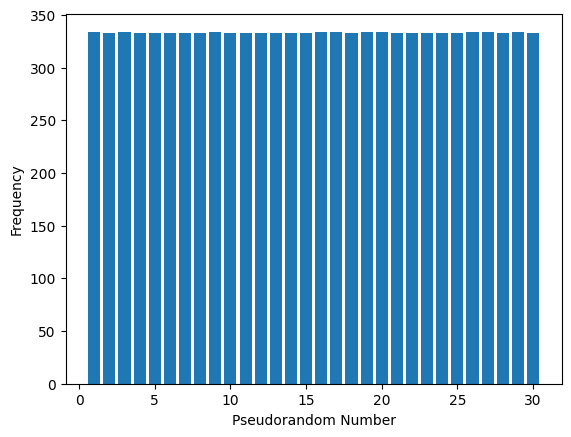

In [74]:
histogram(rngs)

The frequencies of the numbers geenrated by this RNG are well distributed -- except there are no instances of 0!

### Autocorrelation: Square Test and Cube Test

Plotting sequences of consecutive pseudorandom numbers may reveal patterns, indicating the existence of internal correlations (autocorrelations).

In [9]:
def square_test(rngs):
    plt.scatter(rngs[:-1], rngs[1:])
    plt.title("Square Test: Pairs of Consecutive Pseudorandom Numbers")
    plt.xlabel("$x_i$: First Pseudorandom Number")
    plt.ylabel("$x_{i+1}$: Next Pseudorandom Number")
    plt.show()

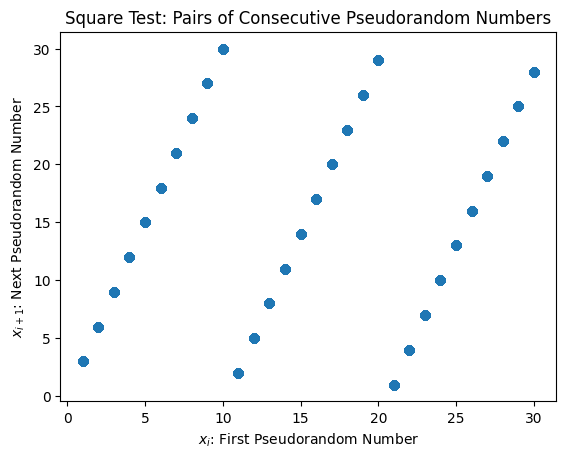

In [10]:
square_test(rngs)

A pattern is evident! The numbers are not randomly distributed, but appear along "planes".

In [11]:
def cube_test(rngs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rngs[:-2], rngs[1:-1], rngs[2:])
    
    plt.title("Cube Test: Triplets of Consecutive Pseudorandom Numbers")
    ax.set_xlabel("$x_i$: First Number")
    ax.set_ylabel("$x_{i+1}$: Second Number")
    ax.set_zlabel("$x_{i+2}$: Third Number")
    plt.show()

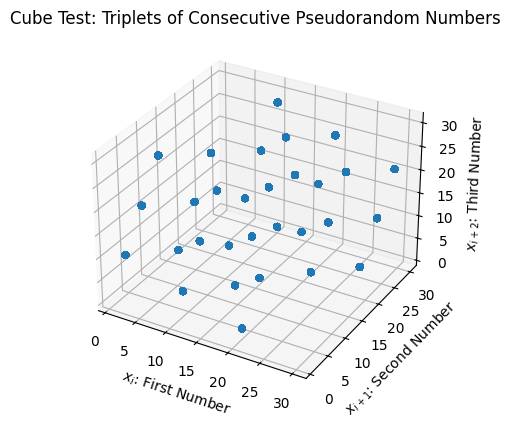

In [12]:
cube_test(rngs)

The pattern in the consecutive triplets also appears to form "planes", perhaps across the $x_{i+2}$ axis, though it is arguably less obvious compared to the consecutive pairs. The fact that (num_iter = 10,000) - 2 = 9,998 triplets reduces to only the number of points seen here (30 -- the number of points in the set of pseudorandomly generated numbers) is itself an indication of a lack of true randomness. Truly random sequences, in which the next number in the sequence is entirely uncoupled from the previous, could be distributed over $x * x$ points in the square test or $x * x * x$ points in the cube test.

## Evaluate a different congruential RNG

In [13]:
c = 5
p = 29
x0 = 1
rngs2 = congruential_rngs(c, p, x0, 100000)
print(rngs2[:30])

[1, 5, 25, 9, 16, 22, 23, 28, 24, 4, 20, 13, 7, 6, 1, 5, 25, 9, 16, 22, 23, 28, 24, 4, 20, 13, 7, 6, 1, 5]


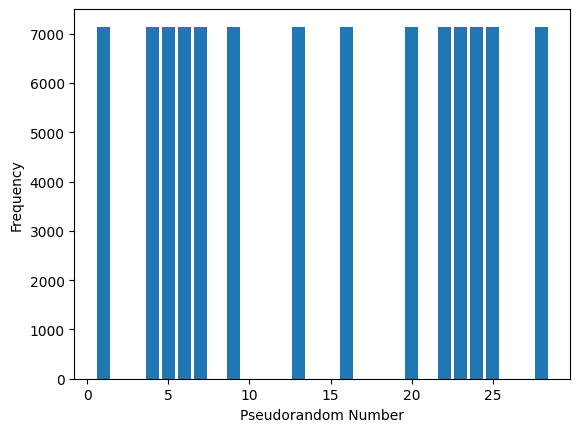

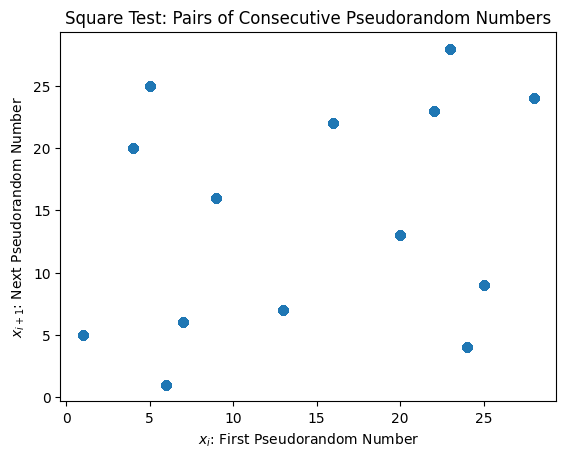

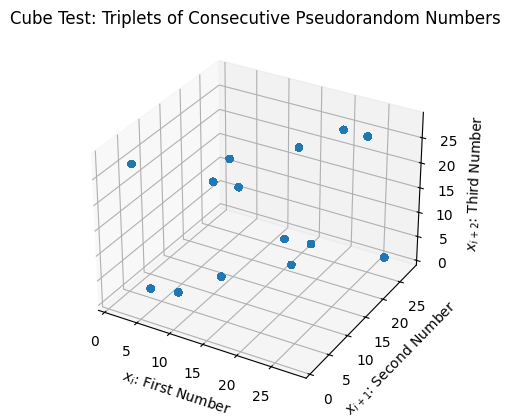

In [75]:
frequencies(rngs2)
histogram(rngs2)
square_test(rngs2)
cube_test(rngs2)

This RNG appears "more random" according to the scatter plot, but skips many numbers entirely, and the number of observed pairs or triplets is very small compared to the number of possible pairs or triplets.

## Chi-squared Test

How much does the histogram deviate from expected? An unbiased random sequence is drawn from a continuous distribution -- that is, we expect each value in an infinitely (or just sufficiently) long random sequence to occur with approximately the same frequency. The $\chi^2$ test measures the deviation of the observed counts of each value in the pseudorandom sequence from the expected counts if drawn from the expected distribution (uniform, in this case). This test is designed for discrete distributions and large sample sizes.

To perform the $\chi^2$ test on a sequence of $n$ pseudorandom numbers, we divide the range of the sequence into $k$ bins -- that is, into $k$ discrete intervals of equal size.  The number of bins (intervals) should be chosen such that the observed count in each bin, $N_i$, is *at least* 5. Combine bins as needed until this criterion is met. The probability of a unformly distributed random number being in a given interval $i$ is $p_i = \frac{1}{k}$. The expected count in each bin is $np_i$.

The $\chi^2$ value, or test statistic, for the pseudorandom sequence is computed by:
$\chi^2 = \sum\limits^{k}_{i=1}\frac{(N_i-np_i)^2}{np_i}$

The resulting $\chi^2$ value can then be compared with a $\chi^2$ table. We find the appropriate row based on the number of bins minus 1 -- that is, the degrees of freedom (DF) -- and the column based on a chosen alpha value (P). If the test statistic is less than or equal to the table value, we accept the null hypothesis: that the pseudorandom sequence appears to come from a uniform distribution, i.e. it meets one criterion for "randomness".

Here is a $\chi^2$ table from https://www.statology.org/how-to-read-chi-square-distribution-table/
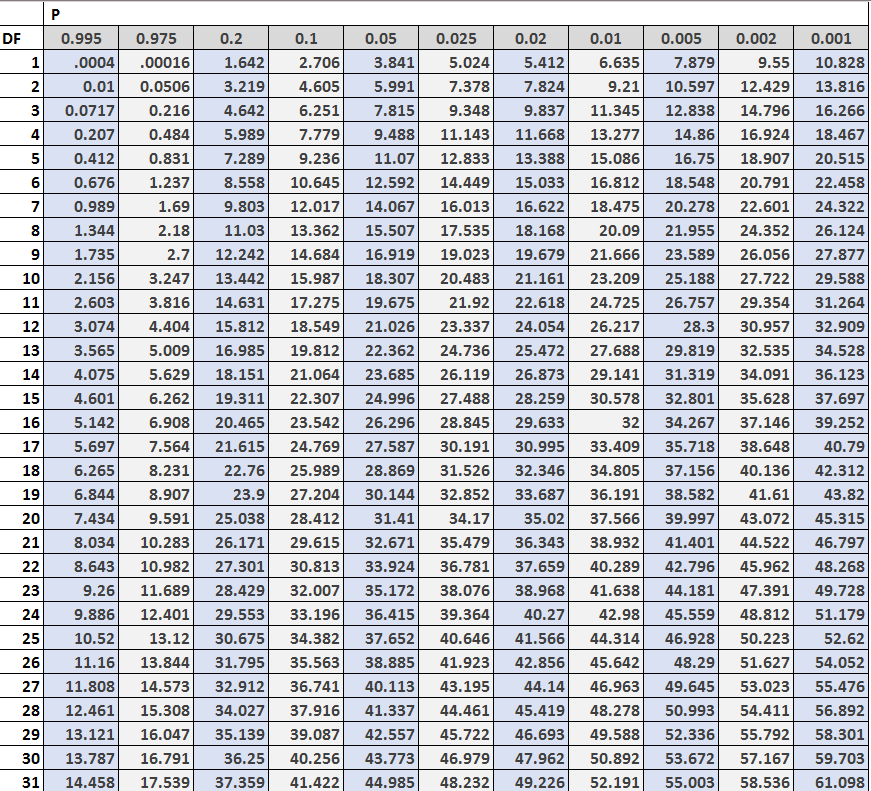

In [68]:
def combine_bins(values, counts, expected_number_of_values, expected_count_per_value):
    """If a bin has less than 5 observations, chi-squared will fail.
       Combine adjacent bins to get a sufficient number of observations."""
    observed = dict(zip(values,counts))
    combined = []
    expected = []
    extra_counts = 0
    extra_bins = 0
    for i in range(expected_number_of_values):
        if i in observed and observed[i] >= 5:
            combined.append(observed[i] + extra_counts)
            expected.append(expected_count_per_value * (1 + extra_bins))
            extra_counts = 0
            extra_bins = 0
        else:
            extra_counts += observed[i] if i in observed else 0
            extra_bins += 1
            if extra_bins > 2 and extra_counts > 5:
                combined.append(extra_counts)
                expected.append(expected_count_per_value * extra_bins)
                extra_counts = 0
                extra_bins = 0
    if (len(combined) > 0):
        combined[-1] += extra_counts
        expected[-1] += expected_count_per_value * extra_bins
    if (len(combined) < 3):
        print("combine_bins failed. Not enough observed values.")
        return
    return zip(combined, expected)

def chi_squared(rngs, expected_number_of_values=p):
    chi_sq = 0
    expected_count = len(rngs) / expected_number_of_values
    values, counts = frequencies(rngs)
    bins = combine_bins(values, counts, expected_number_of_values, expected_count)
    bin_count = 0
    for observed, expected in bins:
        bin_count += 1
        chi_sq += (observed - expected)**2 / expected
    return chi_sq, bin_count - 1

In [69]:
test_statistic, degrees_of_freedom = chi_squared(rngs, 31)
print(f"test statistic = {test_statistic} with DF = {degrees_of_freedom}")

test statistic = 160.44220000000027 with DF = 29


For DF = 29 and P = $\alpha$ = 0.001, the table gives 58.301. We can reject the null hypothesis that the ranodm sequence was generated from a uniform distribution with a 99.9% confidence (confidence level = 1 - $\alpha$ = 0.999 = 99.9%).

## Testing Python's random number generator

In [71]:
import random

pysequence = []
for i in range(10000):
    pysequence.append(random.randint(0,30))

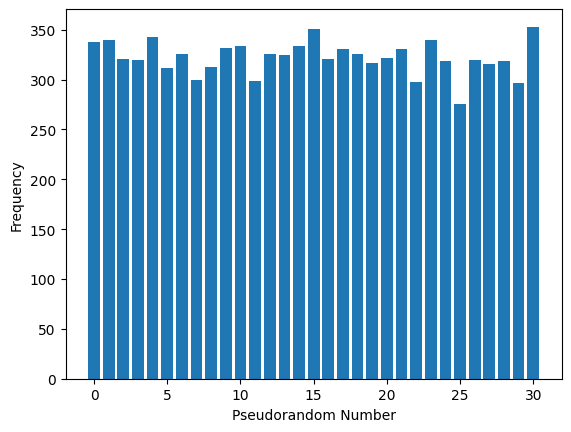

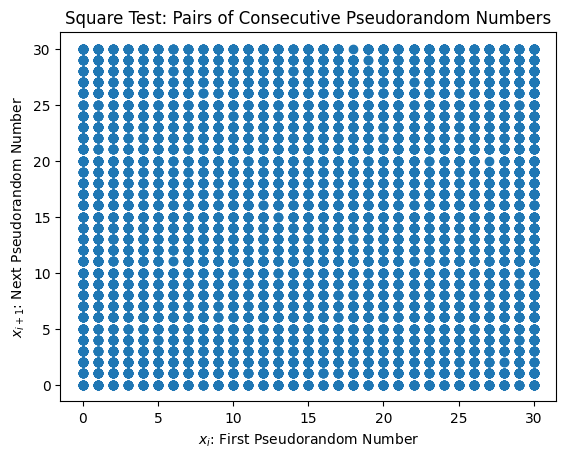

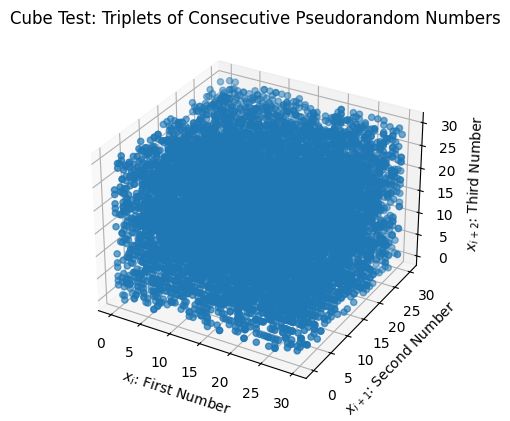

In [76]:
frequencies(pysequence)
histogram(pysequence)
square_test(pysequence)
cube_test(pysequence)

In [77]:
test_statistic, degrees_of_freedom = chi_squared(pysequence, 31)
print(f"test statistic = {test_statistic} with DF = {degrees_of_freedom}")

test statistic = 25.865000000000002 with DF = 30


The $\chi^2$ table gives values 16.971 for P = $\alpha$ = 0.975 and 36.25 for $\alpha$ = 0.2. That means our confidence that Python's random() generates uniformly distributed values is greater than 80% but less than 97.5%.